# <img style="float: left; padding-right: 10px; width: 45px"> GEC AI HUB: Introduction to Data Science and Machine Learning



## Lab 2:  Decision Trees and Random Forests -- Part 2

**GEC AI Hub**<br>
**Summer 2019**<br>
**Instructors:** Pavlos Protopapas<br>
**Lab Instructors:** Patrick Ohiomoba and Esteban Reyes<br>

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals
In this lab, we'll explore tree based models and ensembles in order to solve problems of classification and regression.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - Decision Trees and Random Forest
 
- Be able to understand when Decision Trees and Random Forests overfit 

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.datasets import make_blobs

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

/home/igodo/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/igodo/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/home/igodo/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

### Creating a Decision Tree on Fake data

Let's start by doing what we did in the first lab, creating some fake data in order to motivate understanding of how DecisionTrees work and how to use them.  This time we'll use the make_blob function from sklearn.datasets.  As a result we'll get 4 nice somewhat separated clusters of labelled data.

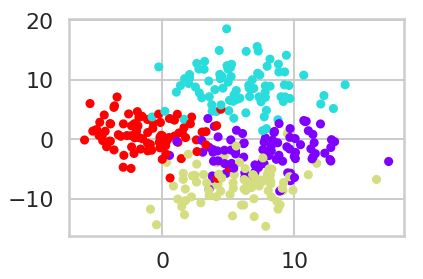

In [41]:
X, y = make_blobs(n_samples=350, centers=4,
                   random_state=3012, cluster_std=3.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [39]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

We can run the Decision tree model almost exactly in the same way as the previous sklearn models because of the consistency of the sklearn API.  Let's create a Decision Treee model and fit it on our data.

/home/igodo/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


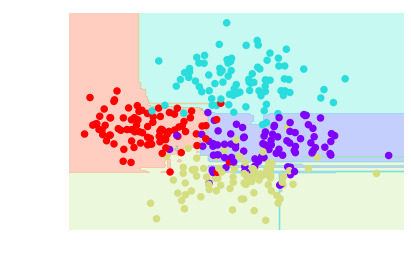

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

/home/igodo/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


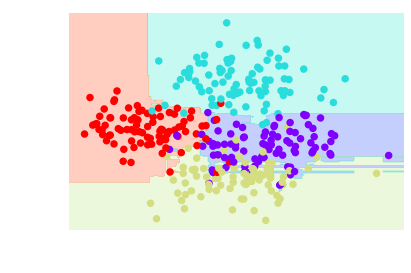

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X, y)
visualize_classifier(rf_model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

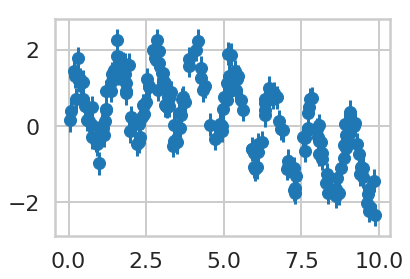

In [43]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

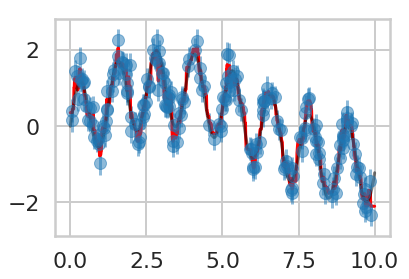

In [46]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

### Regression Tree Example

Recall that we had an example for regression in part 1.  We had a couple of potential hyperparameters to tune -- max_depth and min_samples_split.  We hand tuned and eyeballed them in part 1 of the lab, but is it possible to 

This is what you ought to keep in mind about decision trees.

In [9]:
x = np.arange(0, 2*np.pi, 0.1)
y = np.sin(x) + 0.1*np.random.normal(size=x.shape[0])

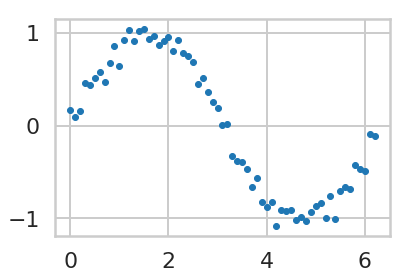

In [10]:
with sns.plotting_context('poster'):
    plt.plot(x,y, '.');

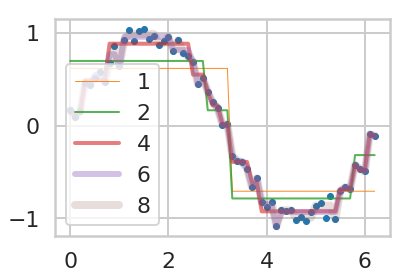

In [11]:
with sns.plotting_context('poster'):
    plt.plot(x,y,'.')
    xx = x.reshape(-1,1)
    for i in [1,2,4,6,8]:
        dtsin = DecisionTreeRegressor(max_depth=i)
        dtsin.fit(xx, y)
        plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
    plt.legend();

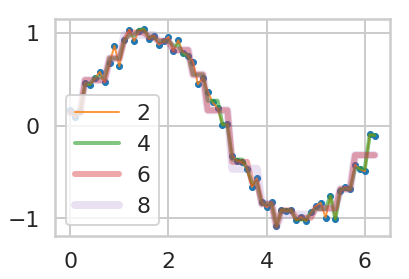

In [12]:
with sns.plotting_context('poster'):
    plt.plot(x,y,'.')
    xx = x.reshape(-1,1)
    for i in [2,4,6,8]:
        dtsin = DecisionTreeRegressor(min_samples_split=i)
        dtsin.fit(xx, y)
        plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
    plt.legend();

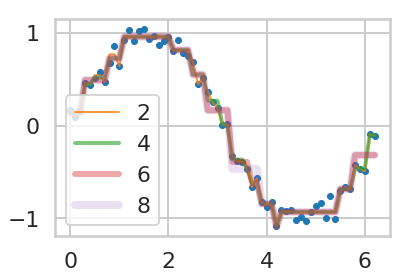

In [13]:
with sns.plotting_context('poster'):
    plt.plot(x,y,'.')
    xx = x.reshape(-1,1)
    for i in [2,4,6,8]:
        dtsin = DecisionTreeRegressor(max_depth=6, min_samples_split=i)
        dtsin.fit(xx, y)
        plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
    plt.legend();

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

### Using Cross Validation and GridSearchCV

In [14]:
from collections import OrderedDict

sin_param_dict = OrderedDict(
    max_depth = [1,2,4,6,8],
    min_samples_split = [2, 4, 6, 8]
)

In [15]:
# do at home
from sklearn.model_selection import GridSearchCV
est = DecisionTreeRegressor()
gs = GridSearchCV(est, param_grid = sin_param_dict, cv=3, n_jobs=-1)
gs.fit(xx, y)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=OrderedDict([('max_depth', [1, 2, 4, 6, 8]), ('min_samples_split', [2, 4, 6, 8])]),
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

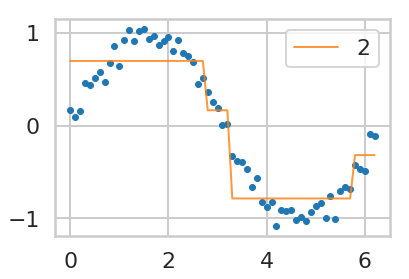

In [16]:
with sns.plotting_context('poster'):
    plt.plot(x,y,'.')
    xx = x.reshape(-1,1)
    i = gs.best_params_['max_depth']
    plt.plot(x, gs.best_estimator_.predict(xx), label=str(i), alpha=1-i/10, lw=i)
    
    plt.legend();

In [17]:
gs.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [18]:
gs.best_params_

{'max_depth': 2, 'min_samples_split': 2}

## Bootstrap-Aggregating (called Bagging)

Whats the basic idea?

- A Single Decision tree is likely to overfit.
- So lets introduce replication through Bootstrap sampling.
- **Bagging** uses bootstrap resampling to create different training datasets. This way each training will give us a different tree.
- Added bonus: the left off points can be used to as a natural "validation" set, so no need to 
- Since we have many trees that we will **average over for prediction**, we can choose a large `max_depth` and we are ok as we will rely on the law of large numbers to shrink this large variance, low bias approach for each individual tree.

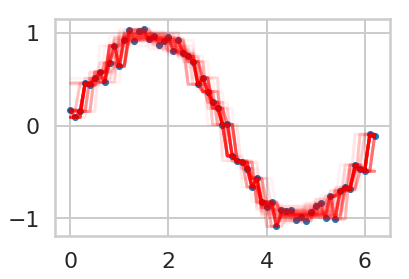

In [19]:
dtsin = DecisionTreeRegressor(max_depth=6)
bagged_dt = BaggingRegressor(dtsin, n_estimators=100, max_samples=0.8,
                        random_state=1)
bagged_dt.fit(xx, y)

with sns.plotting_context('poster'):
    plt.plot(x,y,'.')
    
    for regressor in bagged_dt.estimators_:
        plt.plot(x, regressor.predict(x.reshape(-1,1)), 'r', alpha=0.05)

But this is not enough randomization, because even after bootstrapping, you are mainly training on the same data points, those that appear more often, and will retain some overfitting.

I cant do anything in 1 D but in more than 1D i can choose what predictors to split on randomly, and how many to do this on. This gets us a random forest.

## Dataset

First, the data. This one is built into sklearn, its a dataset about california housing prices. Its quite skewed as we shall see.

In [20]:
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()



In [21]:
cal_housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# split 80/20 train-test
Xtrain, Xtest, ytrain, ytest = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2)
names = cal_housing.feature_names

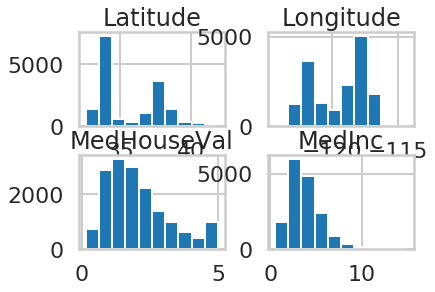

In [24]:
df = pd.DataFrame(data=Xtrain, columns=names)
df['MedHouseVal'] = ytrain
df.hist(column=['Latitude', 'Longitude', 'MedInc', 'MedHouseVal']);

Notice the high bump in the median house value. why do you think that is? How might you model it?

In [25]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,3.8068,34.0,4.630996,0.987085,1516.0,2.797048,34.22,-118.25,2.670
1,4.4271,28.0,5.743056,1.236111,703.0,4.881944,36.86,-121.73,1.757
2,3.7426,20.0,5.940678,1.000000,676.0,2.864407,38.68,-121.24,1.355
3,7.1845,40.0,5.619048,0.972789,389.0,2.646259,33.89,-118.39,4.381
4,3.2019,33.0,6.128571,1.019048,580.0,2.761905,36.34,-119.72,1.125


In [26]:
df.shape

(16512, 9)

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
# code from 
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
param_dict = OrderedDict(
    n_estimators = [50, 100, 150],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

param_dict.values()

odict_values([[50, 100, 150], [0.2, 0.4, 0.6, 0.8]])

In [29]:
Xtrain.shape

(16512, 8)

Here we create a Param Grid. We are preparing to use the bootstrap points not used to validate.

```
max_features : int, float, string or None, optional (default=”auto”)
The number of features to consider when looking for the best split.
```

- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 
- You can "validate" on the trees `n_estimators` as well but many a times you will just look for the plateau in the trees as seen below.
- From decision trees you get the `max_depth`, `min_samples_split`, and `min_samples_leaf` as well but you might as well leave those at defaults to get a maximally expanded tree.

### Using the OOB score.

We have been putting "validate" in quotes. This is because the bootstrap gives us left-over points! So we'll now engage in our very own version of a grid-search, done over the out-of-bag scores that `sklearn` gives us for free

In [30]:
from itertools import product

In [ ]:
results = {}
estimators= {}
for n, f in product(*param_dict.values()):
    params = (n, f)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=n, max_features=f, n_jobs=-1)
    est.fit(Xtrain, ytrain)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

In [ ]:
rf1 = estimators[outparams]

In [ ]:
results

In [ ]:
rf1.score(Xtest, ytest)

Since our response is very skewed, we may want to suppress outliers by using the `mean_absolute_error` instead. 

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, rf1.predict(Xtest))

`sklearn` supports this (`criterion='mae'`) since 0.18, but does not have arbitrary loss functions for Random Forests.

YOUR TURN NOW
>Lets try this with MAE

In [ ]:
# your code here

Finally you can get feature importances. Whenever a feature is used in a tree in the forest, the algorithm will log the decrease in the splitting criterion such as gini. This is accumulated over all trees and reported in `est.feature_importances_`

In [ ]:
pd.Series(rf1.feature_importances_, index=names).sort_values().plot(kind="barh")

You can do cross-validation if you want, and a cv of 3 will roughly be comparable. But this will take much more time as you are doing the fit 3 times plus the bootstraps. So atleast three times as long!

In [31]:
# do at home
param_dict2 = OrderedDict(
    n_estimators = [600],
    max_features = [0.2, 0.4, 0.6]
)

In [32]:
# do at home
from sklearn.model_selection import GridSearchCV
est2 = RandomForestRegressor(oob_score=False)
gs = GridSearchCV(est2, param_grid = param_dict2, cv=3, n_jobs=-1)
gs.fit(Xtrain, ytrain)


/home/igodo/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=OrderedDict([('n_estimators', [600]), ('max_features', [0.2, 0.4, 0.6])]),
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
# do at home
rf2 = gs.best_estimator_
rf2

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
# do at home
gs.best_score_

0.8138510168607349

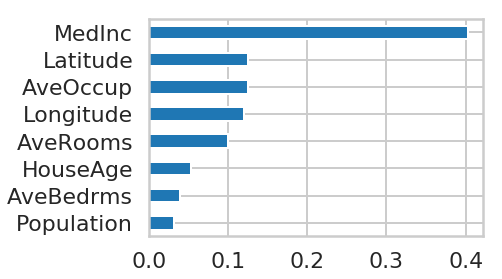

In [35]:
pd.Series(rf2.feature_importances_, index=names).sort_values().plot(kind="barh")

How would you support scoring using mean absolute error if you use cross-validation?

### Seeing error as a function of the number of trees

We can instead, of different `max_features` see how performance varies across the number of trees one uses:

In [36]:
# from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

feats = param_dict['max_features']
# 
error_rate = OrderedDict((label, []) for label in feats)

# Range of `n_estimators` values to explore.
min_estimators = 200
step_estimators = 200
num_steps = 3
max_estimators = min_estimators + step_estimators*num_steps
for label in feats:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf = RandomForestRegressor(oob_score=True, max_features=label)
        clf.set_params(n_estimators=i)
        clf.fit(Xtrain, ytrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

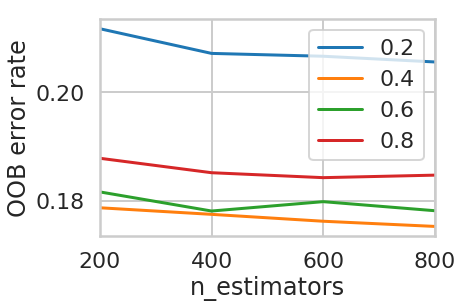

In [37]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()